In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

# Multivariate time series

# II. Machine learning modeling:


#### Metadata:
#### "timestamp" - timestamp field for grouping the data
#### "cnt" - the count of a new bike shares
#### "t1" - real temperature in C
#### "t2" - temperature in C "feels like"
#### "hum" - humidity in percentage
#### "windspeed" - wind speed in km/h
#### "weathercode" - category of the weather
#### "isholiday" - boolean field - 1 holiday / 0 non holiday
#### "isweekend" - boolean field - 1 if the day is weekend
#### "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

#### "weathe_code" category description:
#### 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [4]:
df = pd.read_csv(
  "C:\\Users\\RABBAI\\Downloads\\london_merged.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [5]:
df.shape

(17414, 9)

In [6]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


### Data exploration & feature selection

In [7]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

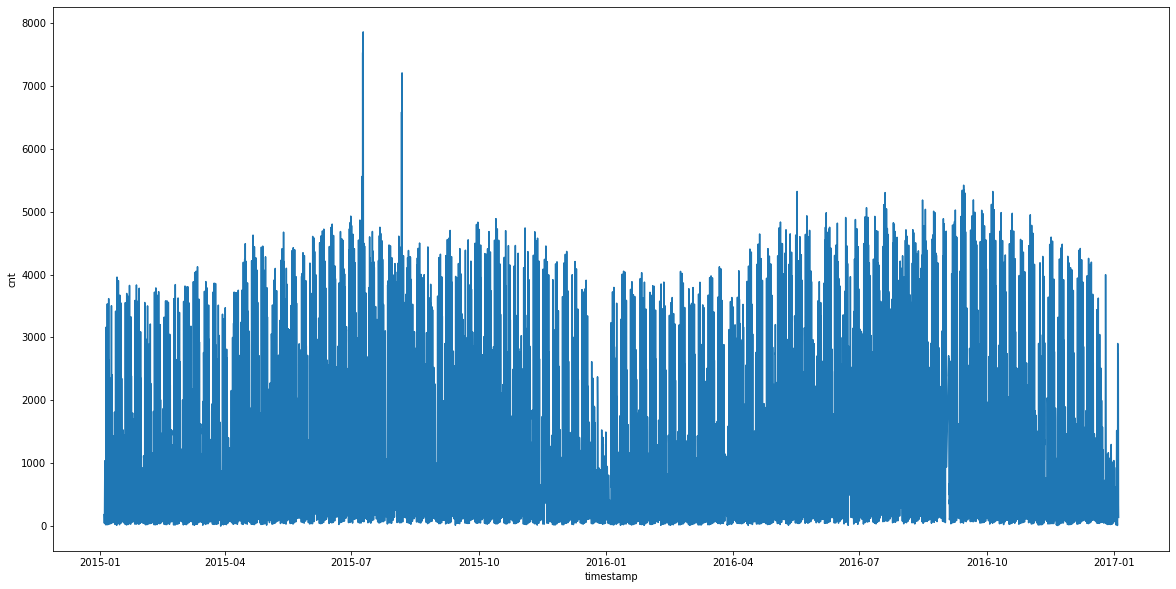

In [9]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y="cnt", data=df);

### We can see that the time series has a seasonality

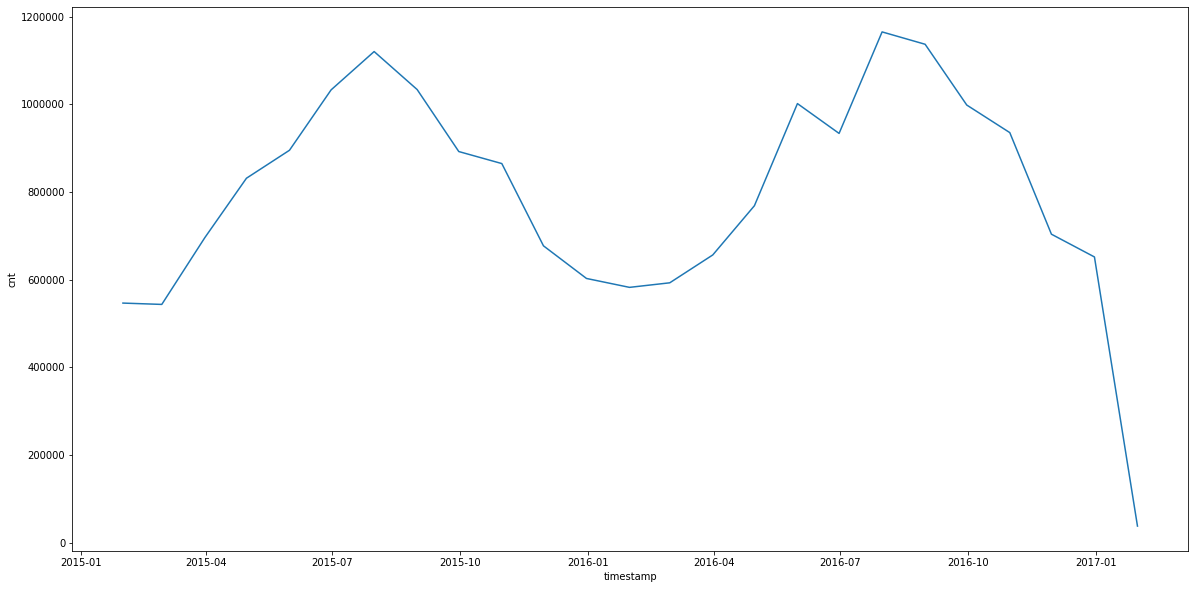

In [12]:
plt.figure(figsize=(20,10))
df_by_month = df.resample('M').sum()
sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

### The hour of the day, holidays, weekends, and season all affect the number of bike shares which makes them good features for our model

### As people tend to use more bikes from 7h-10h and also at the evening from 16h-20h
### The spikes for a holiday differ from the ones of regular days as in holidays bike shares are higher around 11h-17h
### Season also affect the general behavior as in summer the bike shares are higher & in winter they are low

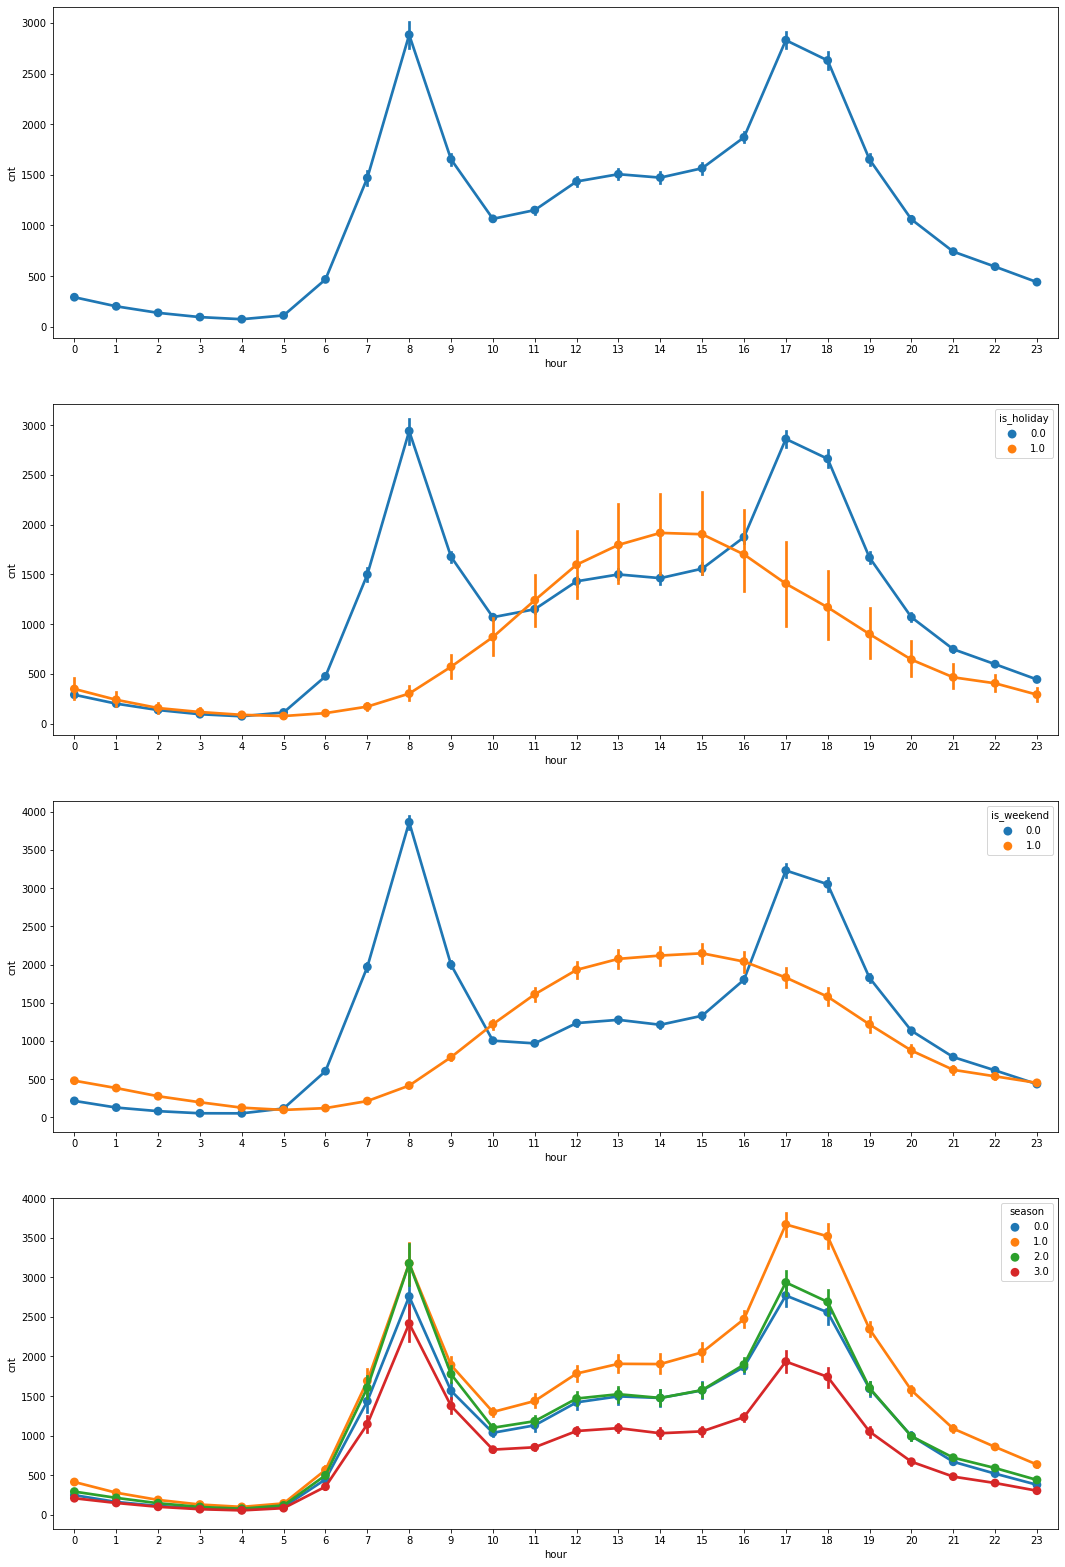

In [13]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)
sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

### The days of the week also has an affect on bike shares are they are higher from monday to friday and they are lower for saturday and sunday

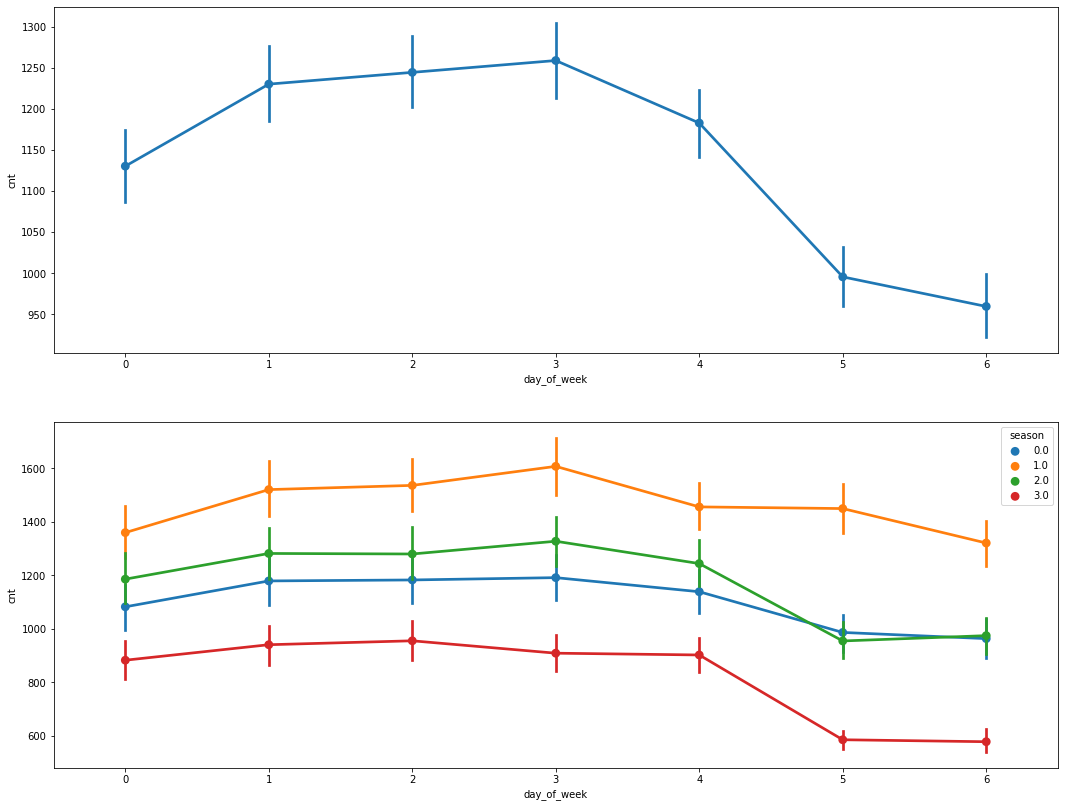

In [14]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [15]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


### Data scaling

In [19]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

### 1. Select one machine learning model from your choice to model the given time series. 

#### The model that will be used to model the data is RNN (LSTM)

### 2. Justify the choice of your model. And prove that this model can be used for time series forecasting.


#### Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. LSTMs have the promise of being able to learn the context required to make predictions in time series forecasting problems, rather than having this context pre-specified and fixed

### 3. Provide the form of the hypothesis set of your model.

### 4. Define the parameters and the hyper-parameters of your model.

In [20]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15648, 24, 13) (15648,)


#### Creating the model

In [23]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

### 5. Explain the functioning of the selected model using mathematical equations and graphs. 


<div>
<img src="https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell_W640.jpg" width="500"/>
</div>

### 6. Provide a set of candidate models. Justify your choice.

#### Without Dropout

In [25]:
model2 = keras.Sequential()
model2.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model2.add(keras.layers.Dense(units=1))
model2.compile(loss='mean_squared_error', optimizer='adam')

#### With Dropout

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

### 7. Choose one learning algorithm to minimize your cost function. Justify your choice.


##### a) Select a learning rate of your algorithm (constant or adaptive learning rate). Justify your choice. If it is adaptive provide the adaption technique.


##### The learning rate is adaptive, since this one provides better results & adapts to the data, the optimizer used is ADAM (adaptive moment estimation optimizer)

### 8. Use your models to learn the parameters based on training data, and save the training performances.

In [24]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 23s 43ms/step - loss: 0.3625 - val_loss: 0.1745
Epoch 2/30
441/441 [==============================] - 16s 37ms/step - loss: 0.1220 - val_loss: 0.0863
Epoch 3/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0724 - val_loss: 0.0455
Epoch 4/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0544 - val_loss: 0.0375
Epoch 5/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0374 - val_loss: 0.0468
Epoch 6/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0315 - val_loss: 0.0393
Epoch 7/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0285 - val_loss: 0.0335
Epoch 8/30
441/441 [==============================] - 17s 38ms/step - loss: 0.0252 - val_loss: 0.0362
Epoch 9/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0242 - val_loss: 0.0310
Epoch 10/30
441/441 [==============================] - 16s 37ms/step - loss: 0.021

In [26]:
history = model2.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 20s 38ms/step - loss: 0.3601 - val_loss: 0.1591
Epoch 2/30
441/441 [==============================] - 16s 36ms/step - loss: 0.1123 - val_loss: 0.0771
Epoch 3/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0636 - val_loss: 0.0681
Epoch 4/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0362 - val_loss: 0.0445
Epoch 5/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0316 - val_loss: 0.0415
Epoch 6/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0316 - val_loss: 0.0354
Epoch 7/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0270 - val_loss: 0.0357
Epoch 8/30
441/441 [==============================] - 16s 37ms/step - loss: 0.0262 - val_loss: 0.0329
Epoch 9/30
441/441 [==============================] - 16s 36ms/step - loss: 0.0253 - val_loss: 0.0304
Epoch 10/30
441/441 [==============================] - 16s 36ms/step - loss: 0.024

### 9. Select the best model using the validation data.

In [30]:
print("Model 1 Val loss = ", model.history.history["val_loss"][-1])
print("Model 2 Val loss = ", model2.history.history["val_loss"][-1])

Model 1 Val loss =  0.02411140501499176
Model 2 Val loss =  0.03290883079171181


### We'll continue using Model 1

### 10. Test your selected model on the testing data and retain your results based on the statistical metrics.


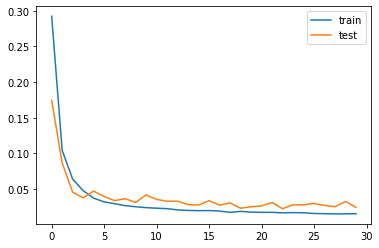

In [28]:
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.legend();

### 11. Is there any overfitting or underfitting problem? 

 #### The validation loss dont increase at the end which indicates the absence of overfitting

### 14. Plot in the same graph the real and estimation training data for statistical and machine learning model. What can you notice?

In [42]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [43]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
y_train_pred_inv = cnt_transformer.inverse_transform(y_train_pred)

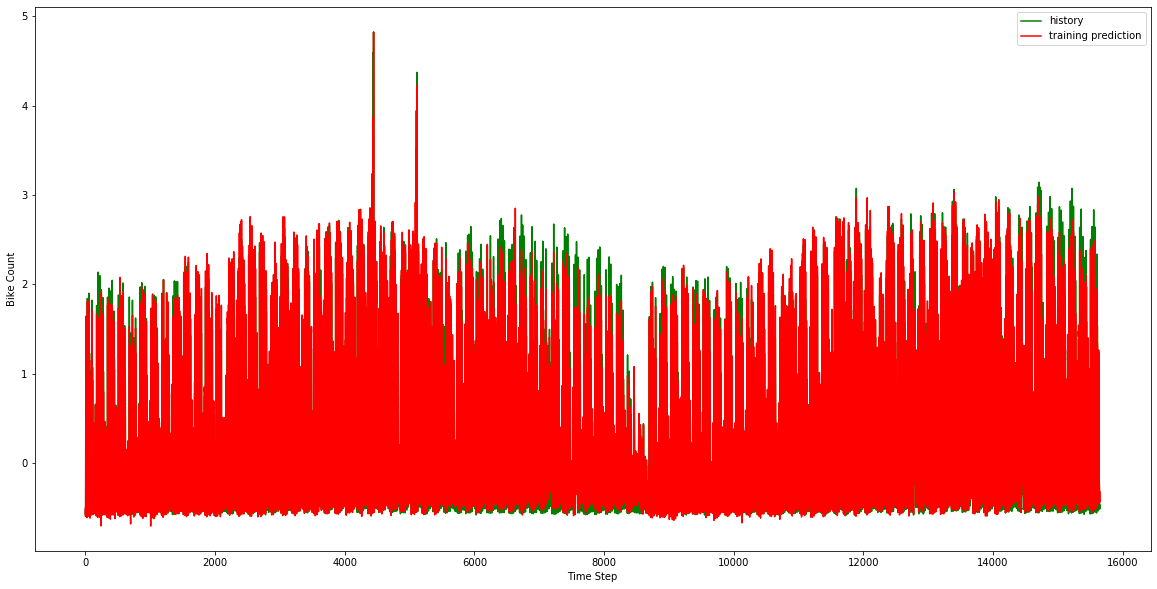

In [46]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")

plt.plot(np.arange(0, len(y_train)), y_train_pred_inv.flatten(), 'r', label="training prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

#### The model has manage to well capture the data even some outliers

### 15. Plot in the same graph the real and estimation testing data for statistical and machine learning model. What can you notice?

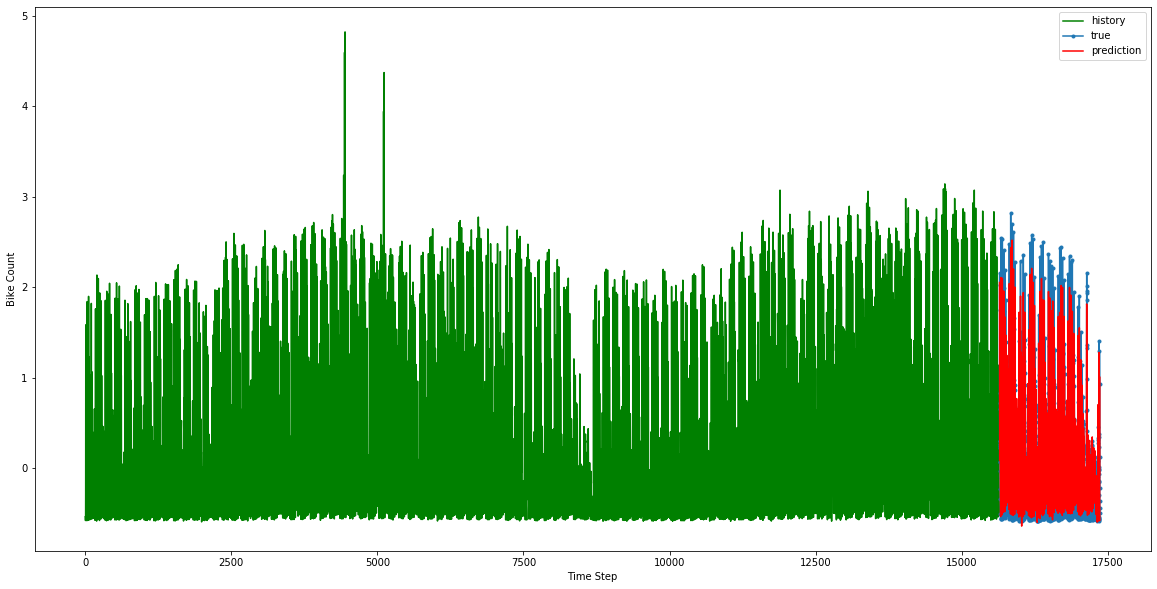

In [47]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();



### The predictions fit well the test data which means our model is good